<a href="https://colab.research.google.com/github/Seouyang/Today-I-Learned/blob/master/cnn_vs_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)
Implement CNN using pytorch and compare it with MLP

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import time 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
linear_layer = nn.Linear(in_features=784, out_features=400)
convolutional_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5, 5))
print(linear_layer.weight.shape) #(output feature size, input feature size)
print(convolutional_layer.weight.shape) #(output channel size, input channel size, kernel height, kernel width)

torch.Size([400, 784])
torch.Size([32, 3, 5, 5])


In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#visualization
def vis_feat(f1, f2, inp):
  l = [f1, f2]
  fig, axes = plt.subplots(11, 8, figsize=(12.5, 12.5))
  plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.1)
  ax = axes[0, 0]
  ax.imshow(inp[0], cmap='gray_r')
  ax.set_title('Original image')
  ax.axis('off')

  for i in range(7):
    ax = axes[0, i+1]
    ax.axis('off')
  
  for i in range(32):
    r = 2 + i // 8
    c = i % 8
    ax = axes[r, c]             
    ax.imshow(f1[i], cmap='gray_r')
    if i == 0:
      ax.set_title('Output from conv1')      
    ax.axis('off')
    if i < 8:
      ax = axes[1, i]
      ax.axis('off')

  for i in range(32):
    r = 7 + i // 8
    c = i % 8
    ax = axes[r, c]             
    ax.imshow(f2[i], cmap='gray_r')
    if i == 0:
      ax.set_title('Output from conv2')      
    ax.axis('off')
    if i < 8:
        ax = axes[6, i]
        ax.axis('off')

  plt.xticks([]), plt.yticks([])
  plt.show()

In [5]:
def vis(model, loader):
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      images, labels = data
      f1 = model.conv1(images)
      f2 = model.conv2(model.pool(F.relu(f1)))

      vis_feat(f1[0], f2[0], images[0])
      break

**Implement of CNN using pytorch**


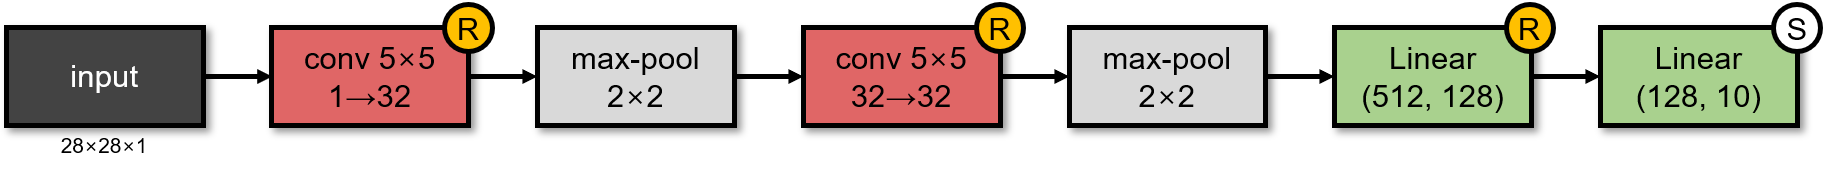

In [6]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5))
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10)
  
  def forward(self, x):
    batchsize = x.size(0)
    x = self.conv1(x)
    x = self.pool(F.relu(x))
    x = self.conv2(x)
    x = self.pool(F.relu(x))
    x = x.view(batchsize, -1)
    x = F.relu(self.fc1(x))
    out = self.fc2(x)
    return out

In [7]:
def train(model, n_epoch, loader, optimizer, criterion, device='cpu'):
  model.train()
  for epoch in tqdm(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print('Epoch {}, loss = {:.3f}'.format(epoch, running_loss / len(loader)))
  print('Training Finished')

In [8]:
def evaluate(model, loader, device='cpu'):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  acc = 100 * correct / total
  return acc

In [10]:
cnn_model = CNN().to("cuda")
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

  7%|▋         | 1/15 [00:05<01:18,  5.57s/it]

Epoch 0, loss = 2.273


 13%|█▎        | 2/15 [00:11<01:12,  5.56s/it]

Epoch 1, loss = 1.565


 20%|██        | 3/15 [00:16<01:06,  5.55s/it]

Epoch 2, loss = 0.507


 27%|██▋       | 4/15 [00:22<01:00,  5.51s/it]

Epoch 3, loss = 0.369


 33%|███▎      | 5/15 [00:27<00:55,  5.56s/it]

Epoch 4, loss = 0.304


 40%|████      | 6/15 [00:33<00:50,  5.59s/it]

Epoch 5, loss = 0.260


 47%|████▋     | 7/15 [00:39<00:44,  5.61s/it]

Epoch 6, loss = 0.227


 53%|█████▎    | 8/15 [00:44<00:38,  5.55s/it]

Epoch 7, loss = 0.200


 60%|██████    | 9/15 [00:50<00:33,  5.63s/it]

Epoch 8, loss = 0.178


 67%|██████▋   | 10/15 [00:55<00:28,  5.61s/it]

Epoch 9, loss = 0.161


 73%|███████▎  | 11/15 [01:01<00:22,  5.55s/it]

Epoch 10, loss = 0.146


 80%|████████  | 12/15 [01:06<00:16,  5.54s/it]

Epoch 11, loss = 0.134


 87%|████████▋ | 13/15 [01:12<00:11,  5.71s/it]

Epoch 12, loss = 0.124


 93%|█████████▎| 14/15 [01:18<00:05,  5.73s/it]

Epoch 13, loss = 0.116


100%|██████████| 15/15 [01:24<00:00,  5.62s/it]

Epoch 14, loss = 0.110
Training Finished


Test accuracy: 97.28%


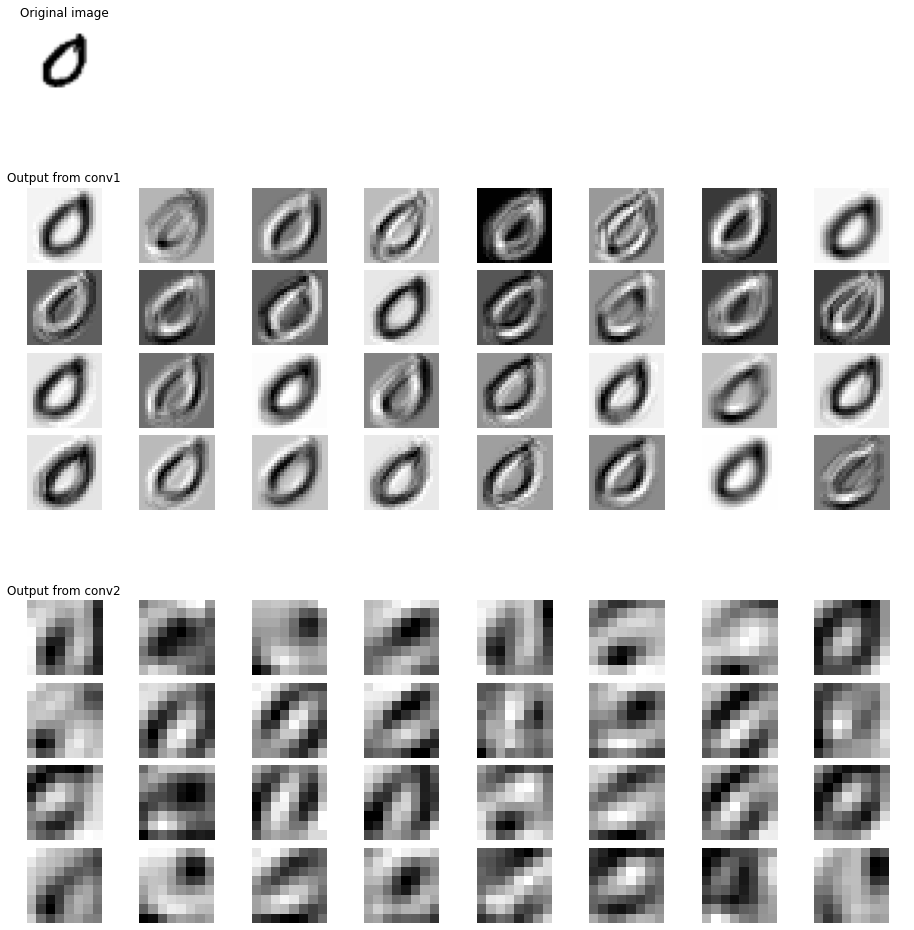

In [11]:
vis(cnn_model.cpu(), trainloader)

**Comparison between CNN and MLP**


*   CNN needs more computations and longer training time
*   CNN has fewer parameters
*   CNN shows higher performance in image processing task


Construct MLP below.
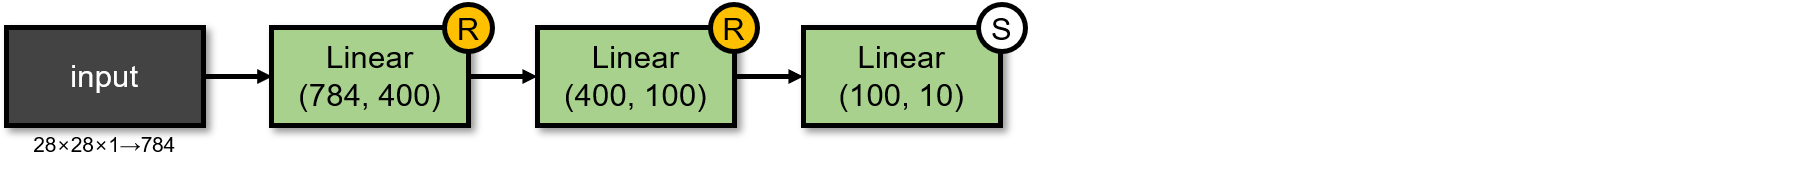



In [12]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(in_features=784, out_features=400)
    self.layer2 = nn.Linear(in_features=400, out_features=100)
    self.layer3 = nn.Linear(in_features=100, out_features=10)
  
  def forward(self, x):
    batchsize = x.size(0)
    x = x.view(batchsize, -1)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    out = self.layer3(x)
    return out

In [13]:
mlp_model = MLP().to("cuda")
optimizer = optim.SGD(params=mlp_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=mlp_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(mlp_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))

  7%|▋         | 1/15 [00:04<01:05,  4.70s/it]

Epoch 0, loss = 2.214


 13%|█▎        | 2/15 [00:08<00:58,  4.50s/it]

Epoch 1, loss = 1.758


 20%|██        | 3/15 [00:13<00:53,  4.44s/it]

Epoch 2, loss = 1.013


 27%|██▋       | 4/15 [00:17<00:48,  4.39s/it]

Epoch 3, loss = 0.667


 33%|███▎      | 5/15 [00:21<00:43,  4.37s/it]

Epoch 4, loss = 0.529


 40%|████      | 6/15 [00:25<00:38,  4.26s/it]

Epoch 5, loss = 0.457


 47%|████▋     | 7/15 [00:30<00:34,  4.32s/it]

Epoch 6, loss = 0.415


 53%|█████▎    | 8/15 [00:34<00:30,  4.32s/it]

Epoch 7, loss = 0.387


 60%|██████    | 9/15 [00:39<00:26,  4.43s/it]

Epoch 8, loss = 0.367


 67%|██████▋   | 10/15 [00:43<00:21,  4.39s/it]

Epoch 9, loss = 0.351


 73%|███████▎  | 11/15 [00:47<00:17,  4.31s/it]

Epoch 10, loss = 0.339


 80%|████████  | 12/15 [00:51<00:13,  4.36s/it]

Epoch 11, loss = 0.328


 87%|████████▋ | 13/15 [00:56<00:08,  4.26s/it]

Epoch 12, loss = 0.319


 93%|█████████▎| 14/15 [01:00<00:04,  4.24s/it]

Epoch 13, loss = 0.310


100%|██████████| 15/15 [01:04<00:00,  4.31s/it]

Epoch 14, loss = 0.302
Training Finished


Test accuracy: 91.67%


In [ ]:
mlp_num_parameters = sum(param.numel() for param in mlp_model.parameters() if param.requires_grad)
mlp_acc = evaluate(mlp_model, testloader, device="cuda")
print('Total Number of trainable parameters of MLP: {}, Accuracy of MLP: {:.2f}%'.format(mlp_num_parameters, mlp_acc))

cnn_num_parameters = sum(param.numel() for param in cnn_model.parameters() if param.requires_grad)
cnn_acc = evaluate(cnn_model, testloader, device="cuda")
print('Total Number of trainable parameters of CNN: {}, Accuracy of CNN: {:.2f}%'.format(cnn_num_parameters, cnn_acc))

Reference: KAIST EE488 lecture practice materials